In [4]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

finaltest = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/translated/'ttest.tsv'.txt")
finaltest["visitors"] = 0

NIKKO NATIONAL PARK

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def encodeTrainTest(train, test):
    train_df = train
    train['datetime'] = pd.to_datetime(train['datetime'])

    #Creating new features with datetime
    train_df["dayofweek"] = train['datetime'].dt.dayofweek
    train_df["dayofweek"] = train_df["dayofweek"].astype('object')
    #train_df.loc[train_df['dayofweek'] == 2, 'dayofweek'] = 1
    #train_df.loc[train_df['dayofweek'] == 3, 'dayofweek'] = 1
    #train_df[train_df["dayofweek"]==2] = 1
    #train_df[train_df["dayofweek"]==3] = 1
    train_df["month"] = train['datetime'].dt.month
    train_df["month"] = train_df["month"].astype('object')
    train_df["year"] = train['datetime'].dt.year
    train_df["year"] = train_df["year"].astype('object')
    train_df["day"] = train['datetime'].dt.day
    train_df["day"] = train_df["day"].astype('object')
    train_df = train_df.drop(["datetime"], axis =1)

    

    #COnverting datetime to cyclic features
    #train_df['dayofweek_sin'] = np.sin(train_df["dayofweek"].astype(int)*(2.*np.pi/7))
    #train_df['dayofweek_cos'] = np.cos(train_df["dayofweek"].astype(int)*(2.*np.pi/7))
    train_df['mnth_sin'] = np.sin((train_df["month"].astype(int)-1)*(2.*np.pi/12))
    train_df['mnth_cos'] = np.cos((train_df["month"].astype(int)-1)*(2.*np.pi/12))
    train_df.drop(['month'], axis =1)
    ##############################################################################
    #Transforming Test Data
    #############################################################################
    #One hot encoding for parks
    test_df = test
    test['datetime'] = pd.to_datetime(test['datetime'])

    #Creating new features with datetime
    test_df["dayofweek"] = test['datetime'].dt.dayofweek
    test_df["dayofweek"] = test_df["dayofweek"].astype('object')
    #test_df.loc[test_df['dayofweek'] == 2, 'dayofweek'] = 1
    #test_df.loc[test_df['dayofweek'] == 3, 'dayofweek'] = 1
    
    test_df["month"] = test['datetime'].dt.month
    test_df["month"] = test_df["month"].astype('object')
    test_df["year"] = test['datetime'].dt.year
    test_df["year"] = test_df["year"].astype('object')
    test_df["day"] = test['datetime'].dt.day
    test_df["day"] = test_df["day"].astype('object')
    test_df = test_df.drop(["datetime"],axis =1)
    
    #test_df['dayofweek_sin'] = np.sin(test_df["dayofweek"].astype(int)*(2.*np.pi/7))
    #test_df['dayofweek_cos'] = np.cos(test_df["dayofweek"].astype(int)*(2.*np.pi/7))
    test_df['mnth_sin'] = np.sin((test_df["month"].astype(int)-1)*(2.*np.pi/12))
    test_df['mnth_cos'] = np.cos((test_df["month"].astype(int)-1)*(2.*np.pi/12))
    test_df.drop(['month'], axis =1)
    
    return train_df, test_df


def fitModelAndPredict(train_df, test_df):
     
    # Load the data
    y_train_full = train_df["visitors"]
    x_train_full = train_df.iloc[:,1:]
    x_test = test_df.iloc[:,1:]

    
    # Convert columns that are not numeric to a numeric value
    for c in x_train_full.columns:
        if x_train_full[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(x_train_full[c].values))
            x_train_full[c] = lbl.transform(list(x_train_full[c].values))
            # x_train_full.drop(c,axis=1,inplace=True)

    for c in x_test.columns:
        if x_test[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(x_test[c].values))
            x_test[c] = lbl.transform(list(x_test[c].values))
            # x_test.drop(c,axis=1,inplace=True)
    
    x_train_full = scaler.fit_transform(x_train_full) 
    x_test = scaler.fit_transform(x_test)

    #Various hyper-parameters to tune
    xgb1 = XGBRegressor()
    #gama = np.linspace(0.1,0.5,9)
    parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['reg:linear'],
                  'learning_rate': [0.01, 0.03], #so called `eta` value
                  'max_depth': [4, 6],
                  'min_child_weight': [0.1, 3],
                  'silent': [1],
                  'subsample': [0.6, 0.8],
                  'colsample_bytree': [0.5, 0.7],
                  'n_estimators': [800],
                  'reg_lambda':[0.1, 0.6],
                  'gamma': [0, 0.6, 3, 50]}

    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 5,
                            n_jobs = 5,
                            verbose=True)
    
    
    model = xgb_grid.fit(x_train_full, y_train_full, eval_metric='rmse')
    #best_model = xgb_grid.best_estimator_
    
    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    #y_pred = model.predict(x_test)
    y_pred = model.predict(x_test)
    return y_pred

In [17]:
akan_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Akan/Akan_train.csv").drop(['epark'], axis =1)
akan_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Akan/Akan_test_new.csv").drop(['serial_number', 'epark'], axis =1)

aso_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Aso/Aso_train.csv").drop(['epark'], axis =1)
aso_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Aso/Aso_test_new.csv").drop(['serial_number', 'epark'], axis =1)

ise_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Ise/Ise_train.csv").drop(['epark'], axis =1)
ise_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Ise/Ise_test_new.csv").drop(['serial_number', 'epark'], axis =1)

kerama_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Kerama/Kerama_train.csv").drop(['epark'], axis =1)
kerama_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Kerama/Kerama_test_new.csv").drop(['serial_number', 'epark'], axis =1)

kirishima_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Kirishima/Kirishima_train.csv").drop(['epark'], axis =1)
kirishima_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Kirishima/Kirishima_test_new.csv").drop(['serial_number', 'epark'], axis =1)

nikko_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Nikko/nikko_train.csv").drop(['Unnamed: 0', 'epark'], axis =1)
nikko_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Nikko/nikko_test_new.csv").drop(['serial_number', 'epark'], axis =1)

oyama_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Oyama/Oyama_train.csv").drop(['epark'], axis =1)
oyama_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Oyama/Oyama_test_new.csv").drop(['serial_number', 'epark'], axis =1)

towada_train = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Towada/towada_train.csv").drop(['epark'], axis =1)
towada_test = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/test_and_train_data/Towada/towada_test_new.csv").drop(['serial_number', 'epark'], axis =1)

In [18]:
oyama_pred_df  = pd.DataFrame()
oyama_pred_df["index"] = oyama_test["index"]
oyama_train, oyama_test = encodeTrainTest(oyama_train, oyama_test)
oyama_pred = fitModelAndPredict(oyama_train, oyama_test)
oyama_pred_df['visitors'] = oyama_pred

towada_pred_df  = pd.DataFrame()
towada_pred_df["index"] = towada_test["index"]
towada_train, towada_test = encodeTrainTest(towada_train, towada_test)
towada_pred = fitModelAndPredict(towada_train, towada_test)
towada_pred_df['visitors'] = towada_pred


akan_pred_df  = pd.DataFrame()
akan_pred_df["index"] = akan_test["index"]
akan_train, akan_test = encodeTrainTest(akan_train, akan_test)
akan_pred = fitModelAndPredict(akan_train, akan_test)
akan_pred_df['visitors'] = akan_pred

aso_pred_df  = pd.DataFrame()
aso_pred_df["index"] = aso_test["index"]
aso_train, aso_test = encodeTrainTest(aso_train, aso_test)
aso_pred = fitModelAndPredict(aso_train, aso_test)
aso_pred_df['visitors'] = aso_pred

ise_pred_df  = pd.DataFrame()
ise_pred_df["index"] = ise_test["index"]
ise_train, ise_test = encodeTrainTest(ise_train, ise_test)
ise_pred = fitModelAndPredict(ise_train, ise_test)
ise_pred_df['visitors'] = ise_pred

kerama_pred_df  = pd.DataFrame()
kerama_pred_df["index"] = kerama_test["index"]
kerama_train, kerama_test = encodeTrainTest(kerama_train, kerama_test)
kerama_pred = fitModelAndPredict(kerama_train, kerama_test)
kerama_pred_df['visitors'] = kerama_pred

kirishima_pred_df  = pd.DataFrame()
kirishima_pred_df["index"] = kirishima_test["index"]
kirishima_train, kirishima_test = encodeTrainTest(kirishima_train, kirishima_test)
kirishima_pred = fitModelAndPredict(kirishima_train, kirishima_test)
kirishima_pred_df['visitors'] = kirishima_pred

nikko_pred_df  = pd.DataFrame()
nikko_pred_df["index"] = nikko_test["index"]
nikko_train, nikko_test = encodeTrainTest(nikko_train, nikko_test)
nikko_pred = fitModelAndPredict(nikko_train, nikko_test)
nikko_pred_df['visitors'] = nikko_pred



Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.21096395165925416
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.6}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   41.4s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 1280 out of 1280 | elapsed:  2.2min finished


0.2982320370811989
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.8}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.20306065676378113
{'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.1, 'silent': 1, 'subsample': 0.8}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.13838463912014515
{'colsample_bytree': 0.7, 'gamma': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.8}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.4391567794718958
{'colsample_bytree': 0.5, 'gamma': 0.6, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.8}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.09303063218787846
{'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.8}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.33245918909309913
{'colsample_bytree': 0.5, 'gamma': 50, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0.1, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.6}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abhishekkumar/anaconda3/envs/signate/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Par

0.24046183048552686
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 800, 'nthread': 4, 'objective': 'reg:linear', 'reg_lambda': 0.6, 'silent': 1, 'subsample': 0.8}


In [14]:

oyama_pred_df1 = oyama_pred_df.copy()
oyama_min = np.min(oyama_train["visitors"])
tmp = oyama_pred_df["visitors"].values
tmp[tmp<=oyama_min] = np.mean(oyama_train["visitors"])
oyama_pred_df["visitors"] = tmp

towada_pred_df1 = towada_pred_df.copy()
towada_min = np.min(towada_train["visitors"])
tmp = towada_pred_df["visitors"].values
tmp[tmp<=towada_min] = np.mean(towada_train["visitors"])
towada_pred_df["visitors"] = tmp

akan_pred_df1 = akan_pred_df.copy()
akan_min = np.min(akan_train["visitors"])
tmp = akan_pred_df["visitors"].values
tmp[tmp<=akan_min] = np.mean(akan_train["visitors"])
akan_pred_df["visitors"] = tmp

aso_pred_df1 = aso_pred_df.copy()
aso_min = np.min(aso_train["visitors"])
tmp = aso_pred_df["visitors"].values
tmp[tmp<=aso_min] = np.mean(aso_train["visitors"])
aso_pred_df["visitors"] = tmp

ise_pred_df1 = ise_pred_df.copy()
ise_min = np.min(ise_train["visitors"])
tmp = ise_pred_df["visitors"].values
tmp[tmp<=ise_min] = np.mean(ise_train["visitors"])
ise_pred_df["visitors"] = tmp

kerama_pred_df1 = kerama_pred_df.copy()
kerama_min = np.min(kerama_train["visitors"])
tmp = kerama_pred_df["visitors"].values
tmp[tmp<=kerama_min] = np.mean(kerama_train["visitors"])
kerama_pred_df["visitors"] = tmp

kirishima_pred_df1 = kirishima_pred_df.copy()
kirishima_min = np.min(kirishima_train["visitors"])
tmp = kirishima_pred_df["visitors"].values
tmp[tmp<=kirishima_min] = np.mean(kirishima_train["visitors"])
kirishima_pred_df["visitors"] = tmp

nikko_pred_df1 = nikko_pred_df.copy()
nikko_min = np.min(nikko_train["visitors"])
tmp = nikko_pred_df["visitors"].values
tmp[tmp<=nikko_min] = np.mean(nikko_train["visitors"])
nikko_pred_df["visitors"] = tmp

In [15]:
pred_df = pd.DataFrame()
pred_df = pd.concat([oyama_pred_df, towada_pred_df, akan_pred_df, aso_pred_df, ise_pred_df, kerama_pred_df, kirishima_pred_df, nikko_pred_df])
pred_df = pred_df.sort_values(['index'], ascending=[1])
pred_df["visitors"] = np.round(pred_df["visitors"]).astype(int)
pred_df.to_csv('/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/sample_submit.tsv',sep='\t',header=False, index =False)

In [20]:
model = xgb.train(params, d_train, 1000, watchlist)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

NameError: name 'params' is not defined

In [21]:
import matplotlib.pyplot as plt
check_df = pd.DataFrame()
check_df["date"] = nikko_test["datetime"]
check_df.index = pd.to_datetime(check_df["date"])

fig = plt.figure(figsize=[16,8])
check_df["visitors"] = y_pred
by_weekday = check_df.groupby(check_df.index.dayofweek)
plt.plot(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],by_weekday.mean())

KeyError: 'datetime'

0         AxesSubplot(0.1,0.679412;0.235294x0.220588)
1    AxesSubplot(0.382353,0.679412;0.235294x0.220588)
2    AxesSubplot(0.664706,0.679412;0.235294x0.220588)
3         AxesSubplot(0.1,0.414706;0.235294x0.220588)
4    AxesSubplot(0.382353,0.414706;0.235294x0.220588)
5    AxesSubplot(0.664706,0.414706;0.235294x0.220588)
6             AxesSubplot(0.1,0.15;0.235294x0.220588)
dtype: object

<Figure size 1440x720 with 0 Axes>

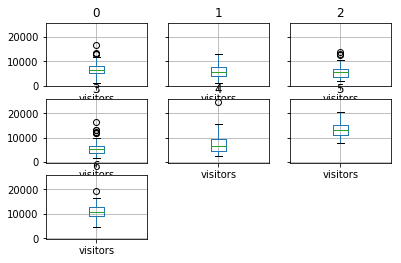

In [109]:
plt.figure(figsize=[20,10])
by_weekday.boxplot()

In [48]:
yt = pd.read_table("/Users/abhishekkumar/Documents/MS_UB/Fall_18/ESL506_StatisticalDataMiningI/Project/SIGNATE/translated/'ttrain.tsv'.txt")



In [50]:
np.std(yt["visitors"])

8790.335852676615